<a href="https://colab.research.google.com/github/tristanpadiou/Travel-assistant/blob/main/app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import torch
torch.cuda.is_available()

False

In [1]:
import pandas as pd
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.agents import initialize_agent, load_tools
from langchain.tools import Tool,tool,StructuredTool
from langchain.prompts import PromptTemplate
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition,InjectedState
from langchain_core.messages import (
    SystemMessage,
    HumanMessage,
    AIMessage,
    ToolMessage,
)
from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.tools.base import InjectedToolCallId

#structuring
import ast

from dataclasses import dataclass
from typing_extensions import TypedDict
from typing import Annotated, Literal
from pydantic import BaseModel, Field
#get graph visuals
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

import pytz
from datetime import datetime
import os
import requests
import json
# import gradio as gr


c:\Users\tristan\localllm\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [172]:
from langchain_experimental.llms.ollama_functions import OllamaFunctions
llm = OllamaFunctions( 
    model="deepseek-r1:7b",
    format="json", # DOES matter for bind_tools
)

In [89]:
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate
parser = JsonOutputParser()

In [114]:
from langchain_ollama import ChatOllama

In [159]:
llm = ChatOllama( 
    model="mistral"
)

In [15]:
@tool
def trip_data_loader(tool_call_id: Annotated[str, InjectedToolCallId],filename: str) -> str:
  """
  Tool to load the trip_data, which is a pickle file.

  Include the extensions in filename. eg. file.pkl.
  """
  # with open(f'/content/drive/MyDrive/{filename}', 'rb') as f:
  #   trip_data=pickle.load(f)
  if filename=='trip_data.pkl':
    trip_data=trip_schedule
    return Command(update={'trip_data':str(trip_data),
                            'messages':[ToolMessage('uploaded the trip_data', tool_call_id=tool_call_id)
                                        ]})


In [175]:
@tool
def schedule_creator(tool_call_id: Annotated[str, InjectedToolCallId], query:str)->str:
  """Tool to create or add a schedule from the chat query with the agent
  and then uses an llm to structure it.
  args: query - the query from the chat
  """
  
  prompt = PromptTemplate(
  template='create a schedule based on the query in a json format in the output, only include the json, no descriptions, do not include ```json```, do not include comments either',
  input_variables=["query"],
  partial_variables={"format_instructions": parser.get_format_instructions()},
  )
  chain = prompt | llm | parser

  result=chain.invoke({"query": query})
  
  return Command(update={'trip_data': result,
                          'messages':[ToolMessage('added a schedule from the chat', tool_call_id=tool_call_id)
                                      ]})


In [17]:
# initializing time and date tool

#creating a schema
class time_tool_schema(BaseModel):
  continent: str = Field(description='continent')
  city: str = Field(description='city')

def date_time_tool(continent: str,city: str) -> str:
  """
  tool to get the current date and time in a city.

  """
  city=city.replace(' ','_')
  query=continent+'/'+city
  timezone = pytz.timezone(query)
  # Get the current time in UTC, and then convert it to the Marrakech timezone
  utc_now = datetime.now(pytz.utc)  # Get current time in UTC
  localized_time = utc_now.astimezone(timezone)  # Convert to Marrakech time
  time=localized_time.strftime('%Y-%m-%d %H:%M:%S')
  return time

current_date_time_tool=StructuredTool.from_function(name='current_date_time_tool', func=date_time_tool, description='To get the current date and time in any city',args_schema=time_tool_schema, return_direct=True)


In [18]:
@tool
def get_schedule(state: Annotated[dict, InjectedState])-> str:
  """
  Use this tool to get the information about the schedule once it has been loaded.
  args: none
  return: schedule
  """
  return state['trip_data']


In [19]:
# state
class State(TypedDict):
  """
  A dictionnary representing the state of the agent.
  """
  messages: Annotated[list, add_messages]
  trip_data: dict




In [166]:
@tool
def schedule_editor(updates:str,state: Annotated[dict, InjectedState],tool_call_id: Annotated[str, InjectedToolCallId])-> str:
  """
  Tool to edit the schedule.
  Pass the updates to the llm to edit the schedule.
  args: updates - the updates to edit the schedule.
  """
  file=state['trip_data']
  prompt = PromptTemplate(
  template='Edit this schedule: {schedule_data} following the instructions in the query, and include the changes in the schedule, but dont mention them specifically, only include the updated schedule in json format in the output, do not include ```json```, do not include comments either',
  input_variables=["schedule_data","query"],
  partial_variables={"format_instructions": parser.get_format_instructions()},
  )
  chain = prompt | llm | parser

  result=chain.invoke({'schedule_data':str(file),"query": updates})
  return Command(
                 update={'trip_data':result,
                          'messages':[ToolMessage('edited the schedule', tool_call_id=tool_call_id)
                                      ]})

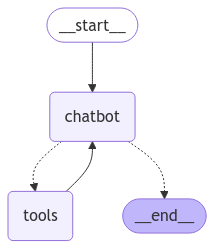

In [176]:
# langgraph
#loading tools
api_tools=load_tools(['wikipedia'])
langgraph_tools=[current_date_time_tool,get_schedule,trip_data_loader,schedule_creator, schedule_editor]+api_tools



graph_builder = StateGraph(State)

# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(langgraph_tools)

def chatbot(state: State):
  """ travel assistant that answers user questions about their trip.
  Depending on the request, leverage which tools to use if necessary."""
  return {"messages": [llm_with_tools.invoke(state['messages'])]}

graph_builder.add_node("chatbot", chatbot)
tool_node = ToolNode(tools=langgraph_tools)
graph_builder.add_node("tools", tool_node)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.set_entry_point("chatbot")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
memory=MemorySaver()
graph = graph_builder.compile(checkpointer=memory)



display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)



In [177]:
config = {"configurable": {"thread_id": "1"}}
input_message = HumanMessage(content=f" using schedule creator, create a schedule based on this info: monday: 12:00pm: lunch,19:00pm:sleep ")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

 using schedule creator, create a schedule based on this info: monday: 12:00pm: lunch,19:00pm:sleep 
================================== Ai Message ==================================
Tool Calls:
  schedule_creator (call_652caca5d93b4323afe79345ab94b73a)
 Call ID: call_652caca5d93b4323afe79345ab94b73a
  Args:
    query: monday: 12:00pm: lunch,19:00pm:sleep
================================= Tool Message =================================
Name: schedule_creator

Error: ValueError('Failed to parse a response from deepseek-r1:7b output: {"query": "Please create a detailed monthly schedule for my business operations including all necessary meetings and tasks, ensuring that each task is assigned to a specific person with its start and end dates."}\n \n\n \n                                  \n                                  \n                                  \n                                  \n                

ValueError: Received unsupported message type for Ollama.

In [164]:
loll=graph.get_state(config).values["trip_data"]

In [165]:
loll

{'Monday': [{'time': '09:00', 'activity': 'Meeting'},
  {'time': '10:30', 'activity': 'Workshop'},
  {'time': '12:30', 'activity': 'Lunch Break'},
  {'time': '13:30', 'activity': 'Coding Session'},
  {'time': '14:30', 'activity': 'Meeting'},
  {'time': '16:00', 'activity': 'Project Review'}],
 'Tuesday': [{'time': '09:00', 'activity': 'Team Meeting'},
  {'time': '10:30', 'activity': 'Design Session'},
  {'time': '12:30', 'activity': 'Lunch Break'},
  {'time': '13:30', 'activity': 'Coding Session'},
  {'time': '14:30', 'activity': 'Project Review'}],
 'Wednesday': [{'time': '09:00', 'activity': 'Meeting'},
  {'time': '10:30', 'activity': 'Workshop Modification'},
  {'time': '12:30', 'activity': 'Lunch Break'},
  {'time': '13:30', 'activity': 'Coding Session'},
  {'time': '14:30', 'activity': 'Meeting'}],
 'Thursday': [{'time': '09:00', 'activity': 'Team Meeting'},
  {'time': '10:30', 'activity': 'Design Session'},
  {'time': '12:30', 'activity': 'Lunch Break'},
  {'time': '13:30', 'acti

In [ ]:
def travel_agent(query,history):
  history_langchain_format = []
  for msg in history:
      if msg['role'] == "user":
          history_langchain_format.append(HumanMessage(content=msg['content']))
      elif msg['role'] == "assistant":
          history_langchain_format.append(AIMessage(content=msg['content']))
  history_langchain_format.append(HumanMessage(content=query))
  return graph.invoke({'messages':history_langchain_format})['messages'][-1].content

In [ ]:
travel_agent('What is planned janvier 2 in the schedule, the schedule is in the get_trip_schedule tool','')

"I cannot answer your question because the available tools do not allow me to access a trip schedule.  The `get_trip_schedule` tool is not working correctly.  It requires a parameter, but I don't know what that parameter should be."

In [ ]:
# interface=gr.ChatInterface(
#     travel_agent,
#     type='messages'
# )
# interface.launch(share=True,debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://b7614156361350b707.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://b7614156361350b707.gradio.live
